# Inaugural Project

Imports and set magics:

In [5]:
# import packages
import numpy as np
import matplotlib.pyplot as plt  

# import your own code
from HouseholdSpecializationModel import HouseholdSpecializationModelClass

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Question 1

### **Method:**

The model is solved using the HouseholdSpecializationModelClass in the following way:

- Create an instance of the class with baseline parameters.
- Use the method, ```calc_utility()```, to calculate all the possible utilities.
- Use the method, ```solve_discrete()```, to maximize utility by findind the optimal level of $H_M, H_F, L_M, L_F$.
- Do this for different values of $\alpha$ and $\sigma$.

#### **Create instance of the model class:**

In [6]:
model = HouseholdSpecializationModelClass()

#### **Setup:**

In [4]:
# create lists of parameters
sigmas = [0.5, 1.0, 1.5]
alphas = [0.25, 0.5, 0.75]

#### **Run model for different values of $\sigma$:**

/Users/andreas/projects-2023-andreas/inauguralproject/HouseholdSpecializationModel.py:91: RuntimeWarning: invalid value encountered in reciprocal
  utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)


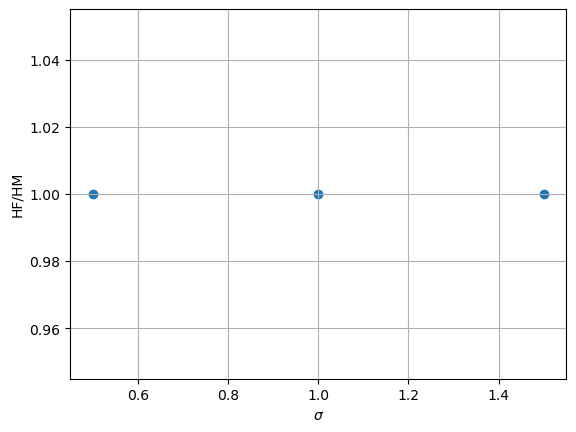

In [6]:
# reset to baseline parameters
model.__init__()

# solve the model for different sigmas
model.solve_multi_par('sigma',sigmas,discrete=True)

# plot the solutions for different sigmas
model.plot_multi_par(sigmas,x_lab=r'$\sigma$',y_lab=r'HF/HM')

#### **Run model for different values of $\alpha$:**

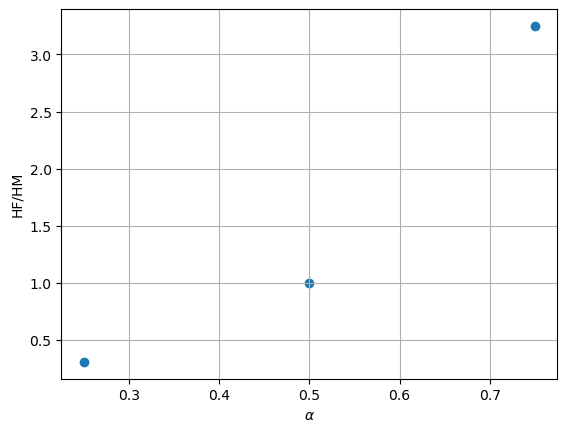

In [92]:
# reset to baseline parameters
model.__init__()

# solve the model for different alphas
model.solve_multi_par('alpha',alphas,discrete=True)

# plot the solutions for different alphas
model.plot_multi_par(alphas,x_lab=r'$\alpha$',y_lab=r'HF/HM')

#### **Economic intepretation:**

#### It is evident that the house work ratio, $H_F/H_M$, does not change with the elasticity of substitution, $\sigma$. Each sex works the same amount, though a high elasticity of substitution, $\sigma$, allows them to change their relative workload and keep the same house production. This is because there is no incentive to do so. I.e. each sex is equally productive as $\alpha = 0.5$, and their wages, $w_F$ and $w_M$, are equivalent. However, if we change $\alpha = 0.25$, the house work ratio decreases as the elasticity of subsitution increases:

/Users/andreas/projects-2023-andreas/inauguralproject/HouseholdSpecializationModel.py:91: RuntimeWarning: invalid value encountered in reciprocal
  utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)


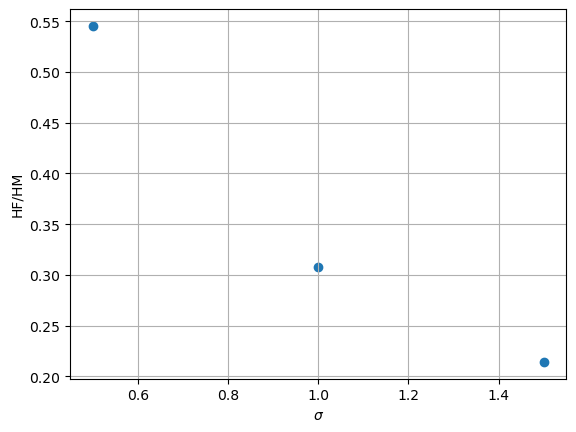

In [93]:
# reset to baseline parameters
model.__init__()

# set alpha to 0.25
setattr(model.par,'alpha',0.25)

# solve the model for different alphas
model.solve_multi_par('sigma',sigmas,discrete=True)

# plot the solutions for different alphas
model.plot_multi_par(sigmas,x_lab=r'$\sigma$',y_lab=r'HF/HM')

# Question 2

#### **Setup:**

In [8]:
# list of wages
wages = [0.8,0.9,1.0,1.1,1.2]

# list of x values for plot
log_wages = [np.log(x/model.par.wM) for x in wages]

#### **Run model for different values of $w_F$:**

/Users/andreas/projects-2023-andreas/inauguralproject/HouseholdSpecializationModel.py:91: RuntimeWarning: invalid value encountered in reciprocal
  utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)


-0.24515592810252862
-0.24199760739013737
-0.2381348402636772
-0.2341393303073075
-0.2297433958951961


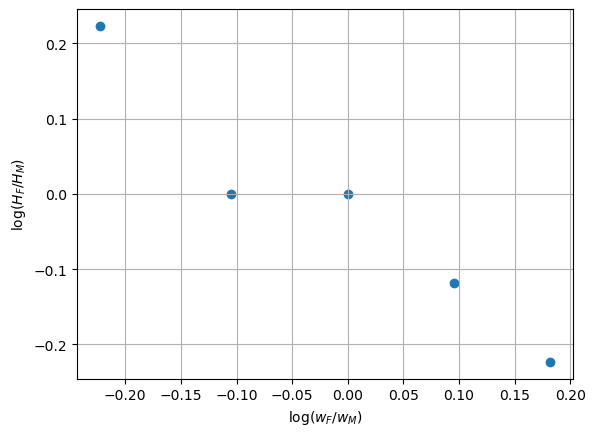

[[6.  4.  3.  5. ]
 [5.  4.5 4.  4.5]
 [4.5 4.5 4.5 4.5]
 [4.  4.5 5.  4. ]
 [3.  5.  5.5 4. ]]


In [21]:
# reset to baseline parameters
model.__init__()

# solve the model for different wages
model.solve_multi_par('wF',wages,discrete=True)

# plot the solutions for different wages
model.plot_multi_par(log_wages,y_function=lambda y: np.log(y),x_lab=r'$\log(w_F/w_M)$',y_lab=r'$\log(H_F/H_M)$')

print(model.sol.array)

#### **Economic intepretation:**

#### The plot above indicates a negative correlation between the house work ratio, $H_F/H_M$, and the wage ratio, $w_F/w_M$. In other words, when the female wage increases, she tends to do less house work relative to her husband. The elasticity of substitution, $\sigma=1$ in the Cobb-Douglas case, keeps them from completely reallocating such that the female worker does all the market work, while the male worker does all the house work. If $\sigma$ was higher, it would be easier for the couple to reallocate their time. The plot below illustrates this; as $\sigma = 2.0$ it makes the house work ratio, $H_F/H_M$, decrease even more as $w_F$ increases.

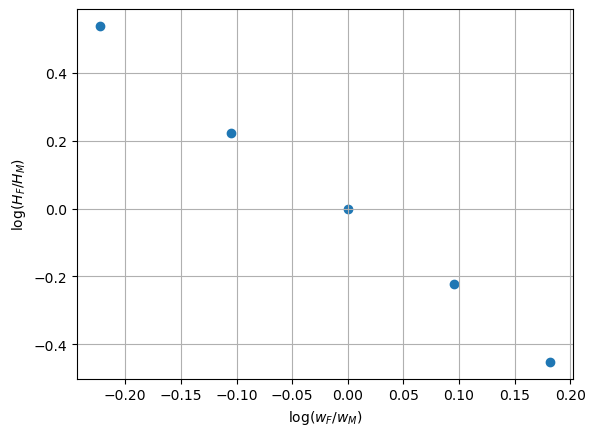

In [9]:
# reset to baseline parameters
model.__init__()

# set sigma to 2.0
setattr(model.par,'sigma',2.0)

# solve the model for different wages
model.solve_multi_par('wF',wages,discrete=True)

# plot the solutions for different wages
model.plot_multi_par(log_wages,y_function=lambda y: np.log(y),x_lab=r'$\log(w_F/w_M)$',y_lab=r'$\log(H_F/H_M)$')

# Question 3

#### **Now, we run the model for different wages, $w_F$, but with a continuous choice set by using a numerical optimizer:**

0.245106579787683
0.24188121864668927
0.2381101577952427
0.23400363890522152
0.22971438227162164


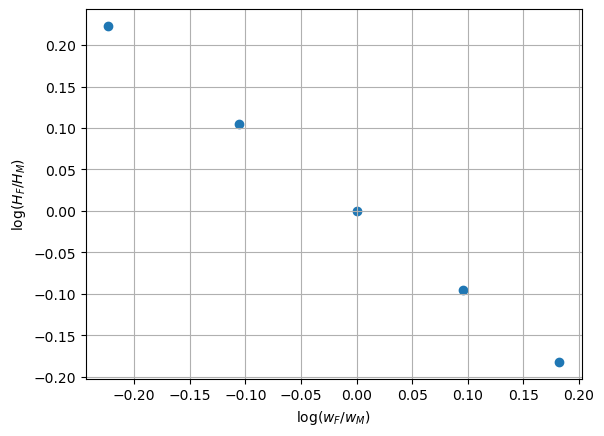

[[5.88926676 4.0925527  2.86979605 5.11567763]
 [5.16773512 4.27104963 3.74930027 4.74561162]
 [4.45449586 4.45449465 4.45449377 4.45449363]
 [3.75978718 4.64196217 5.02195133 4.21996872]
 [3.08971521 4.83262788 5.47961855 4.02719098]]


In [12]:
# reset to baseline parameters
model.__init__()

# solve the model for different wages
model.solve_multi_par('wF',wages,discrete=False)

# plot the solutions for different wages
model.plot_multi_par(log_wages,y_function=lambda y: np.log(y),x_lab=r'$\log(w_F/w_M)$',y_lab=r'$\log(H_F/H_M)$')

print(model.sol.array)

In [37]:
A = np.array([[1,1,0,0],[0,0,1,1]])
x = np.array([[2,2,2,2]])
print(A)
print(x)

[[1 1 0 0]
 [0 0 1 1]]
[[2 2 2 2]]


In [26]:
model.par.wF = 1.2

for row in sol_con:
    print(model.calc_utility_(sol))

print(model.calc_utility(3,5,5.5,4))

print(model.calc_utility(4.0567,4.3850,4.6940,4.3777))

print(model.calc_utility_(np.array([3,5,5.5,4])))

print(model.calc_utility_(np.array([4.0567,4.3850,4.6940,4.3777])))

NameError: name 'sol' is not defined

# Question 4

#### **Run regression to get $\hat{\beta}_0$ and $\hat{\beta}_1$:**

In [18]:
# set baseline parameters
model.__init__()

# estimate model
model.estimate()

Deviation:0.6258080601182134
Deviation:0.17931636710189283
Deviation:0.1957268102661952
Deviation:0.049418885888531786
Deviation:0.02027286210310176
Deviation:0.3587983796364996
Deviation:0.36863585111230335
Deviation:5.340984429492113
Deviation:57.61643344073416
Deviation:3.6343028361798106
Deviation:2.6077530001789695
Deviation:0.26240846751071656
Deviation:2.5329025685659987
Deviation:5.768828123440679
Deviation:6.53669676768766
Deviation:6.653978305350412
Deviation:2.404561936861768
Deviation:2.6976948424919107
Deviation:3.863030408001329
Deviation:11.23907521186752
Deviation:3.7156410479660686
Deviation:0.5647992736404484
Deviation:0.8150773238966902
Deviation:6.910594079605785
Deviation:2.493343322088162
Deviation:0.9020251940367571
Deviation:10.00599404586048
Deviation:54.211702034099254
Deviation:0.12225549784993958
Deviation:4.514173571095013
Deviation:0.925876409057443
Deviation:0.13514632796986317
Deviation:1.0302205719621709
Deviation:0.22072406101278186
Deviation:1.7489739

/Users/andreas/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/andreas/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Deviation:23.49501762466143
Deviation:0.7756522916628008
Deviation:0.3054764181284016
Deviation:2.6118967296483415
Deviation:0.16743960818522652
Deviation:2.9635202086631396
Deviation:1.014096230871666
Deviation:0.024553465019759003
Deviation:1.8264111520927675
Deviation:1.0646060163878601
Deviation:0.42822767223338143
Deviation:13.63477113376415
Deviation:3.272666513338317
Deviation:5.004536919992565
Deviation:3.895166806992694
Deviation:0.17138480086095398
Deviation:0.17044747709374414
Deviation:1.2744735630705608
Deviation:0.5018095811038341
Deviation:6.760457328470299
Deviation:7.207197519709334
Deviation:0.26031239343644463
Deviation:16.66547355453952
Deviation:0.9657768836222331


/Users/andreas/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Deviation:0.11108144190435407
Deviation:0.14890036447181335
Deviation:8.623722237379472
Deviation:0.15201258316270988
Deviation:0.15609517271238435
Deviation:0.009795021400967585
Deviation:3.731802732698965
Deviation:0.09194980070207413
Deviation:8.474080656691413
Deviation:0.4026324497941964
Deviation:0.1437206362033056
Deviation:0.10549621047680884
Deviation:0.04095853619460846
Deviation:0.7189587101597403
Deviation:0.018074743354394858
Deviation:0.042510445852438294
Deviation:2.1141376641621252
Deviation:0.008673556004615418
Deviation:0.25657252709324474
Deviation:0.15466692527054615
Deviation:5.8414663217395635
Deviation:0.06717988523955977
Deviation:0.015701419720917334
Deviation:3.737580742014234
Deviation:0.008979547205050458
Deviation:0.046721068739610516
Deviation:2.0956487404383637
Deviation:0.008972772731306755
Deviation:0.1369368276081109
Deviation:1.3288976980012972
Deviation:1.7591245260879678
Deviation:0.1662468697366247
Deviation:0.10596895176892496
Deviation:0.09367116

/Users/andreas/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/andreas/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/andreas/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining th

Deviation:2.141441916472002
Deviation:0.356628334328016
Deviation:8.579991231596042
Deviation:0.09028916871551604
Deviation:0.043166023556061396
Deviation:6.453750212628332
Deviation:2.8334165697381053
Deviation:0.15376018438793762
Deviation:1.391914329196664
Deviation:0.019456085534843133
Deviation:0.03306656022544202
Deviation:2.9080962783180553
Deviation:0.16976124604797016
Deviation:0.7899027185058676
Deviation:0.3771405089232405
Deviation:0.021895333505345768
Deviation:0.16781115726732931
Deviation:1.0949064365946053
Deviation:0.11836794091310995
Deviation:0.1402499962406003
Deviation:0.010862403477583863
Deviation:0.009705519000560884
Deviation:0.05676980999193939
Deviation:0.01819208590135993
Deviation:0.0888204856457146
Deviation:0.1261168140106666
Deviation:9.472012786912467
Deviation:4.367572751281843
Deviation:0.14616156261928664
Deviation:3.4090349932421464
Deviation:0.018590440490715548
Deviation:0.01546248113450436
Deviation:0.02654240547400831
Deviation:0.041243224880957

/Users/andreas/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/andreas/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Deviation:1.497145340221141
Deviation:0.6985443403620386
Deviation:0.005685395636422021
Deviation:0.08374506766961545
Deviation:0.011172420064432961
Deviation:0.011650355652182642
Deviation:3.5542135209061048
Deviation:0.06362134303644776
Deviation:0.013952413592371475
Deviation:0.05177277292929412
Deviation:0.9612452178383253
Deviation:0.001908652682249862
Deviation:0.1202500974030179
Deviation:0.006671513291655906
Deviation:0.021949232643807243
Deviation:0.01965939498188734
Deviation:0.20907239495891003
Deviation:0.00282319453218534
Deviation:0.08656869836102986
Deviation:0.07429980220582522
Deviation:0.003303382300389142
Deviation:0.05528642985999991
Deviation:0.02398933772266122
Deviation:0.005424305428774724
Deviation:0.0005866671918528492
Deviation:0.010539286460211798
Deviation:0.06143558787402645
Deviation:0.3545168364287749
Deviation:0.05968927449823783
Deviation:0.23387580997163437
Deviation:0.0055213854447081715
Deviation:0.045233823817314014
Deviation:0.04261001807044677
De

/Users/andreas/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Deviation:0.005479899739149987
Deviation:0.005059669690582804
Deviation:0.07375853947364427
Deviation:0.003431249941838609
Deviation:0.01630453408224075
Deviation:0.00341396126145313
Deviation:0.01440989152269392
Deviation:0.14971896543880148
Deviation:0.0017671309717430745
Deviation:0.004604371390395826
Deviation:0.0009143406216002299
Deviation:0.004318296950466898
Deviation:0.16256564652768182
Deviation:0.005804515518238605
Deviation:0.007103529957437106
Deviation:0.14666573259022644


/Users/andreas/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Deviation:0.19595603260037797
Deviation:0.012392884359427259
Deviation:0.003476990683106472
Deviation:0.14348008214959324
Deviation:0.019411085995387153
Deviation:0.04738008651222115
Deviation:0.15597824855908585
Deviation:0.1656127730736774
Deviation:0.002823328643731616


/Users/andreas/projects-2023-andreas/inauguralproject/HouseholdSpecializationModel.py:118: RuntimeWarning: overflow encountered in double_scalars
  term2 = self.par.alpha * x[3]**exponent
/Users/andreas/projects-2023-andreas/inauguralproject/HouseholdSpecializationModel.py:117: RuntimeWarning: overflow encountered in double_scalars
  term1 = (1 - self.par.alpha) * x[1]**exponent


Deviation:0.1634815100693028
Deviation:0.004498730145833808
Deviation:0.003791211872770994
Deviation:0.006366684364273768
Deviation:0.006947807494013045
Deviation:0.0021897031169758672
Deviation:0.004130952679987003
Deviation:0.0005866849989727219
Deviation:0.0005866584047608741


/Users/andreas/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Deviation:0.0005866671896765928
Deviation:184.47152309146685
Deviation:191.33155762937335
Deviation:179.8579469278263
Deviation:0.0005866676063563201
Deviation:0.0005866644618965622
Deviation:0.0005866711606485912
Deviation:0.0005866737970957026
Deviation:0.000586665417694148
Deviation:0.000586659333795271
Deviation:0.0005866596090539636
Deviation:0.0005866578326256739
Deviation:0.0005866662827115861
Deviation:0.0005866614112092607
Deviation:0.0005866743448327308
Deviation:0.000586663539635703
Deviation:0.000586665920911053
Deviation:0.000586676554989585
Deviation:0.0005866618927872842
Deviation:0.0005866791175120228
Deviation:0.0005866741764492763
Deviation:0.0005866618848691213


In [23]:
print((0.4 - model.sol.beta0) ** 2 + (-0.1 - model.sol.beta1) ** 2)
print(model.par.alpha)
model.par.sigma

0.0005866618848691213
0.9659450982323717


0.11358126361405357

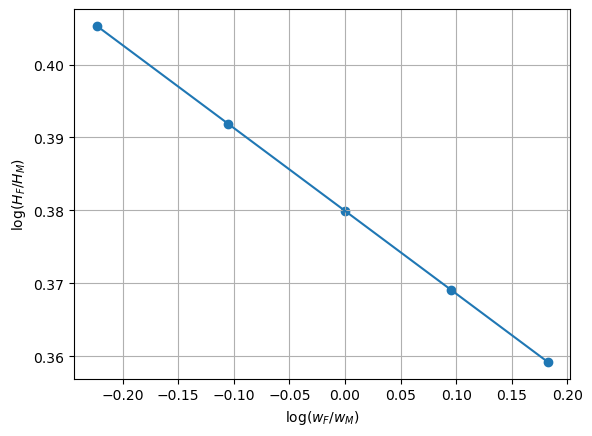

In [20]:
# plot the solutions for different wages
model.plot_multi_par(log_wages,y_function=lambda y: np.log(y),x_lab=r'$\log(w_F/w_M)$',y_lab=r'$\log(H_F/H_M)$',show_reg=True)

#### **Economic interpretation:**

#### The estimated $\beta_1$ by Siminski and Yetsenga (2002) suggests that the house work ratio, $H_F/H_M$, decreases by 0,1 pct. when the wage ratio, $w_F/w_M$, increases by 1 pct. One could argue that this is a relatively weak relationship compared to what one would expect. Intuitively, one would expect the female worker to do much less house work, $H_F$, if her wage increased relative to the male wage.<b>

#### To account for this weak correlation, $\beta_1=-0.1$, the model estimation perfomed above results in a very high $\alpha=0.97$ and a very low $\sigma=0.11$. That is, the only way the present model can explain the weak correlation is if the female worker is far more productive at home, $\alpha=0.97$, and the couple cannot easily substitute house work between them, $\sigma=0.11$. 

#### In other words, when the female wage, $w_F$ increases relative to the male wage, $w_M$, the couple cannot afford to reallocate their time such that the female partner does less house work, $H_F \downarrow$, beacuse 1) the female partner is far more productive at house work than the male partner (high $\alpha$), and 2) both partners much contribute a lot to achieve high $H$ (low $\sigma$ - almost corresponds to $H_F$ and $H_M$ being perfect complements).

# Question 5

#### Model expansions:

#### **The easy one:** On average the female wage, $w_F$, is lower than the male wage, $w_M$. This could in theory explain why an increasing female wage does not translate into a lower house work ratio, $H_F/H_M$. The marginal income from increasing female market work, $L_F \uparrow$, would not be as high as the marginal income from increasing male market work, $L_M$. The estimation below is conducted under the assumption that ```par.wM=5.0```, and this results in lower $\alpha$ and higher $\sigma$. However, ```par.wM=5.0``` is admittedly a very high wage (approximately five time higher than $w_F$) and cannot really be considered a model expansion.

#### **The hard one:** If both sexes are equally productive at home, $\alpha = 0.5$, then an alternative explaination for the weak correlation between $H_F/H_M$ and $w_F/w_M$ 

In [31]:
model.__init__()

model.par.wM = 5.0

model.estimate()

/Users/andreas/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/andreas/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Squared deviation: 0.11986115224369182
Squared deviation: 0.010384142923108844
Squared deviation: 0.38234811111233147
Squared deviation: 0.5133615683522792
Squared deviation: 3.2320043647407055
Squared deviation: 2.397240176598648
Squared deviation: 0.18923098826019244
Squared deviation: 5.606175733919479
Squared deviation: 0.07932432029593847
Squared deviation: 0.141140228358503
Squared deviation: 0.9328974858694211
Squared deviation: 2.163402160334745
Squared deviation: 0.07318521274223402
Squared deviation: 0.11824195367140204
Squared deviation: 0.4372809331873237
Squared deviation: 6.813951000081977
Squared deviation: 0.06868918823811805
Squared deviation: 2.6766572355754135
Squared deviation: 0.4059403665835448
Squared deviation: 0.18480565871883076
Squared deviation: 6.108878745075312


/Users/andreas/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/andreas/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Squared deviation: 0.36576772289989967
Squared deviation: 1.8809171878348308
Squared deviation: 0.010272563107169005
Squared deviation: 1.8902692830595766
Squared deviation: 0.2655780931424251


/Users/andreas/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/andreas/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Squared deviation: 0.06998538622450294
Squared deviation: 0.14154589826390354
Squared deviation: 0.88323148836241
Squared deviation: 2.4676382644509376
Squared deviation: 0.0764942359112799
Squared deviation: 0.2276431415645048
Squared deviation: 0.3175306168059798
Squared deviation: 1.1479212852902212
Squared deviation: 0.29746566144532444
Squared deviation: 0.057095654756988794
Squared deviation: 13.388675522153964
Squared deviation: 0.06808732082204856
Squared deviation: 0.014480658698985422
Squared deviation: 0.052775323247528656
Squared deviation: 0.4636906589244573
Squared deviation: 0.17880352676779518
Squared deviation: 0.262082091681552
Squared deviation: 0.10425742273266737
Squared deviation: 0.016059956484154092
Squared deviation: 0.03812128014314777
Squared deviation: 0.025520485456088683
Squared deviation: 0.010755063017896506
Squared deviation: 0.10902774170836785
Squared deviation: 0.02172171837466847
Squared deviation: 0.03094376529299963
Squared deviation: 0.1570040655

In [33]:
model.par.alpha
model.par.sigma

0.6171614013414993

/Users/andreas/projects-2023-andreas/inauguralproject/HouseholdSpecializationModel.py:276: RuntimeWarning: invalid value encountered in true_divide
  frac = self.sol.array[:,3]/self.sol.array[:,1]


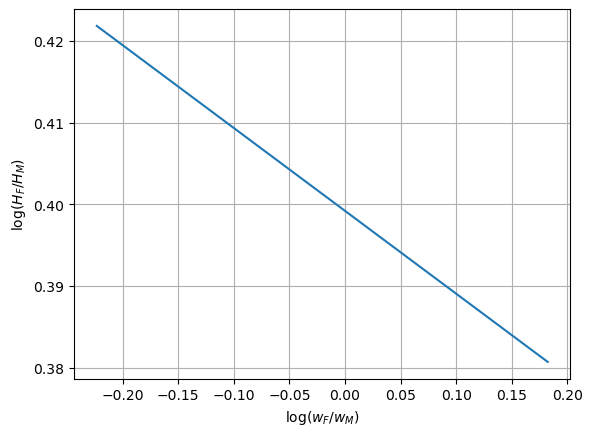

In [25]:
# plot the solutions for different wages
model.plot_multi_par(log_wages,y_function=lambda y: np.log(y),x_lab=r'$\log(w_F/w_M)$',y_lab=r'$\log(H_F/H_M)$',show_reg=True)